# WGMS MB profile and seasonal MB data filtering and data analysis

- produces WGMS data analysis overview csv of amount of observations (MB_profile, summer/winter/annual MB)
    - save it under `oggm-sample-data/wgms/wgms_data_stats_20220301.csv`
- filters winter MB data by getting meta-data about the Begin and End periods of the winter time periods
    - if they do not exist or are unvalid time points -> remove those measurement years as they can not be used
    - only take those glaciers where we have at least 5 winter MB data and 10 annual MB data
    - save them inside of `oggm-sample-data/wgms/mb_overview_seasonal_mb_time_periods_20220301.csv`

In [75]:
working_dir = '/home/lilianschuster/Schreibtisch/PhD/bayes_2022/bayes_oggm_folder_2022'

import numpy as np 
import pandas as pd
import xarray as xr
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib

# %matplotlib inline
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, flowline, climate
import logging
log = logging.getLogger(__name__)

# from drounce_analyze_mcmc import effective_n, mcse_batchmeans
# plotting bayesian stuff
import arviz as az
az.rcParams['stats.hdi_prob'] = 0.95


cfg.initialize() #logging_level='WARNING'
cfg.PARAMS['use_multiprocessing'] = True

cfg.PARAMS['continue_on_error'] = True

#if cluster:
cfg.PATHS['working_dir'] = working_dir
# use Huss flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')


# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data
from MBsandbox.help_func import get_mean_mb_profile_filtered


cfg.PARAMS['hydro_month_nh']=1
cfg.PARAMS['hydro_month_sh']=1

2022-03-01 15:27:16: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-03-01 15:27:16: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-03-01 15:27:16: oggm.cfg: Multiprocessing: using all available processors (N=8)
2022-03-01 15:27:16: oggm.cfg: Multiprocessing switched ON after user settings.
2022-03-01 15:27:16: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2022-03-01 15:27:16: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2022-03-01 15:27:16: oggm.cfg: PARAMS['hydro_month_sh'] changed from `4` to `1`.


In [76]:
ref_candidates = oggm.utils.get_ref_mb_glaciers_candidates()
baseline_climate = 'W5E5'
load = False
if load:
    gdirs = workflow.init_glacier_directories(
                ref_candidates,
                from_prepro_level=2,
                prepro_border=10,
                prepro_base_url=base_url,
                prepro_rgi_version='62')
    t=workflow.execute_entity_task(tasks.compute_downstream_line, gdirs)
    t=workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs)
    #if baseline_climate == 'W5E5':
    #if mb_type != 'mb_monthly':
    #else:
    t = workflow.execute_entity_task(process_w5e5_data, gdirs, climate_type=baseline_climate,
                                  temporal_resol='monthly')
    #else:
    t = workflow.execute_entity_task(process_w5e5_data, gdirs, climate_type=baseline_climate,
                                     temporal_resol='daily')
    #t = workflow.execute_entity_task(process_era5_daily_data, gdirs, #climate_type=baseline_climate,
                              #temporal_resol='daily'process_era5_daily_data(gd)
    #                                )
else:
    gdirs = workflow.init_glacier_directories(
                ref_candidates)
#gdirs = oggm.utils.get_ref_mb_glaciers(gdirs, y0=1979, y1=2020) # at the moment it only goes untill 2018, but this hshould be updated anyways .. 
#ref_glaciers_10msm = []
#for gdir in gdirs:
#    if len(gdir.get_ref_mb_data(input_filesuffix='_daily_W5E5')) > 9:
#        ref_glaciers_10msm.append(gdir.rgi_id)

#rgi = 'RGI60-11.00897'
#gdirs = workflow.init_glacier_directories(rgi)

2022-03-01 15:27:16: oggm.workflow: Execute entity tasks [GlacierDirectory] on 290 glaciers


In [77]:
pd_working = pd.DataFrame(ref_candidates, columns=['rgi_id'])
pd_working['MB_profile'] = False
pd_working['exist_diff_total_winter_summer_above_100'] = False
pd_working['len_mb_profile'] = 0
pd_working['len_summer_balance'] = 0
pd_working['len_winter_balance'] = 0
pd_working.index = ref_candidates
input_fs = '_monthly_W5E5'
working_MB_profiles = []
working_summer_MB = {}
working_winter_MB = {}
for gdir in gdirs:
    try:
        # mb_profile data:
        # check if there are any, and if yes how many years
        mb_prof_filtered, ys_glac = get_mean_mb_profile_filtered(gdir, input_fs=input_fs)
        working_MB_profiles.append(gdir.rgi_id)
        pd_working.loc[gdir.rgi_id, 'MB_profile'] = True
        pd_working.loc[gdir.rgi_id, 'len_mb_profile'] = len(ys_glac)
    except:
        pass
    try:
        # get annual total and seasonal MB
        mb = gdir.get_ref_mb_data(input_filesuffix=input_fs)
        # difference between annual and winter+summer: should be normally quite equal
        total_min_win_sum = (mb['ANNUAL_BALANCE'] - (mb['WINTER_BALANCE']+mb['SUMMER_BALANCE']))
        pd_working.loc[gdir.rgi_id, 'len_annual_balance'] = len(mb['ANNUAL_BALANCE'].dropna())

        
        # only take those years of seasonal MB where annual balance coincides to winter_balance -summer_balance in a good enough way
        # only takes those years where both Winter and Summer balance exist (only thing that makes sense??? )
        condi = total_min_win_sum[(total_min_win_sum<100)] # | (np.isnan(total_min_win_sum))]
        
        pd_working.loc[gdir.rgi_id, 'len_summer_balance'] = len(mb['SUMMER_BALANCE'][condi.index].dropna())
        pd_working.loc[gdir.rgi_id, 'len_winter_balance'] = len(mb['WINTER_BALANCE'][condi.index].dropna())
        if len(total_min_win_sum[total_min_win_sum>=100]) > 0:
            pd_working.loc[gdir.rgi_id, 'exist_diff_total_winter_summer_above_100'] = True

    except:
        pass

2022-03-01 15:27:24: oggm.utils: You are trying to set MB data on a tidewater glacier! These data will be ignored by the MB model calibration routine.
2022-03-01 15:27:24: oggm.utils: You are trying to set MB data on a tidewater glacier! These data will be ignored by the MB model calibration routine.
2022-03-01 15:27:24: oggm.utils: You are trying to set MB data on a tidewater glacier! These data will be ignored by the MB model calibration routine.
2022-03-01 15:27:26: oggm.utils: You are trying to set MB data on a tidewater glacier! These data will be ignored by the MB model calibration routine.
2022-03-01 15:27:36: oggm.utils: You are trying to set MB data on a tidewater glacier! These data will be ignored by the MB model calibration routine.
2022-03-01 15:27:36: oggm.utils: You are trying to set MB data on a tidewater glacier! These data will be ignored by the MB model calibration routine.
2022-03-01 15:27:36: oggm.utils: You are trying to set MB data on a tidewater glacier! These d

In [78]:
for n in [1, 5, 10]:
    for tipe in ['annual', 'winter', 'summer']:
        print('Number of glaciers with at least {} measurement(s) of {} MB: {}'.format(n, tipe, len(pd_working[pd_working['len_{}_balance'.format(tipe)] >= n])))
    print('\n')

Number of glaciers with at least 1 measurement(s) of annual MB: 259
Number of glaciers with at least 1 measurement(s) of winter MB: 181
Number of glaciers with at least 1 measurement(s) of summer MB: 181


Number of glaciers with at least 5 measurement(s) of annual MB: 247
Number of glaciers with at least 5 measurement(s) of winter MB: 159
Number of glaciers with at least 5 measurement(s) of summer MB: 159


Number of glaciers with at least 10 measurement(s) of annual MB: 180
Number of glaciers with at least 10 measurement(s) of winter MB: 114
Number of glaciers with at least 10 measurement(s) of summer MB: 114




In [79]:
pd_working.to_csv('wgms_data_stats_20220301.csv')

In [80]:
pd_working

,rgi_id,MB_profile,exist_diff_total_winter_summer_above_100,len_mb_profile,len_summer_balance,len_winter_balance,len_annual_balance
RGI60-19.00595,RGI60-19.00595,True,False,20,0,0,20.0
RGI60-19.01992,RGI60-19.01992,False,False,0,5,5,6.0
RGI60-19.02101,RGI60-19.02101,False,False,0,0,0,0.0
RGI60-19.02056,RGI60-19.02056,False,False,0,18,18,18.0
RGI60-19.02059,RGI60-19.02059,False,False,0,18,18,18.0
...,...,...,...,...,...,...,...
RGI60-02.17023,RGI60-02.17023,False,False,0,15,15,15.0
RGI60-02.17789,RGI60-02.17789,False,False,0,0,0,10.0
RGI60-01.01390,RGI60-01.01390,False,False,0,25,25,41.0
RGI60-01.09162,RGI60-01.09162,False,False,0,41,41,41.0


reference glacier container that gives information:
 - if MB profile exists
 - if there have been large discrepancies between summer + winter compared to annual MB
 - about amount of years with MB profiles (of at least 5 height msm)
 - about amount of years with summer mass balance for time period 1980-2019
 - about amount of years with winter mass balance for time period 1980-2019
 - about amount of years with annual mass balance for time period 1980-2019

In [81]:
pd_working_mb_prof = pd_working[pd_working.MB_profile.dropna()]
n_mb_prof = len(pd_working_mb_prof)
print(f'Number of glaciers with sufficient measurements to use MB profiles: {n_mb_prof}')
n = 5
n_mb_prof_plus_5_season_mb = len(pd_working_mb_prof[pd_working_mb_prof['len_{}_balance'.format(tipe)] >= n])
print(f'Number of glaciers with sufficient measurements to use MB profiles and at least {n} seasonal measurements: {n_mb_prof_plus_5_season_mb}')
n = 10
n_mb_prof_plus_5_season_mb = len(pd_working_mb_prof[pd_working_mb_prof['len_{}_balance'.format(tipe)] >= n])
print(f'Number of glaciers with sufficient measurements to use MB profiles and at least {n} seasonal measurements: {n_mb_prof_plus_5_season_mb}')


Number of glaciers with sufficient measurements to use MB profiles: 93
Number of glaciers with sufficient measurements to use MB profiles and at least 5 seasonal measurements: 80
Number of glaciers with sufficient measurements to use MB profiles and at least 10 seasonal measurements: 75


## Let's analyse the seasonal MB data a bit more and save the correct time periods!

In [82]:
pd_working = pd.read_csv('wgms_data_stats_20220301.csv', index_col = 'Unnamed: 0')

In [83]:
pd_working = pd_working.loc[pd_working.len_annual_balance >= 10] 

In [84]:
pd_working_winter = pd_working.loc[pd_working.len_winter_balance >=5]
pd_working_winter.index = pd_working_winter.rgi_id
pd_link_wgms,_ = utils.get_wgms_files()#pd.read_csv('/home/lilianschuster/oggm-sample-data/wgms/rgi_wgms_links_20220112.csv')
pd_link_wgms.index = pd_link_wgms.RGI60_ID
pd_working_winter['WGMS_ID'] = pd_link_wgms.loc[pd_working_winter.rgi_id]['WGMS_ID'].values

<ipython-input-84-979950e0262e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_working_winter['WGMS_ID'] = pd_link_wgms.loc[pd_working_winter.rgi_id]['WGMS_ID'].values


In [85]:
# amount of glaciers with at least 5 winter mass balances
# so far unfiltered, hence I take all even if they do not indicate when their MB estimates were computed
len(pd_working_winter.rgi_id.index)

125

In [86]:
pd_working_winter

,rgi_id,MB_profile,exist_diff_total_winter_summer_above_100,len_mb_profile,len_summer_balance,len_winter_balance,len_annual_balance,WGMS_ID
rgi_id,,,,,,,,
RGI60-19.02056,RGI60-19.02056,False,False,0,18,18,18.0,3367
RGI60-19.02059,RGI60-19.02059,False,False,0,18,18,18.0,3366
RGI60-17.14681,RGI60-17.14681,False,False,0,6,6,12.0,3903
RGI60-17.14682,RGI60-17.14682,False,False,0,6,6,12.0,3902
RGI60-17.02128,RGI60-17.02128,False,False,0,18,18,19.0,2000
...,...,...,...,...,...,...,...,...
RGI60-02.17612,RGI60-02.17612,False,False,0,15,15,24.0,1665
RGI60-02.18778,RGI60-02.18778,False,False,0,41,41,41.0,205
RGI60-02.17023,RGI60-02.17023,False,False,0,15,15,15.0,218


#### Get meta-data about direct glaciological mass balance

In [87]:
#outf, datadir = utils.get_wgms_files()
#path_mb_overview = datadir[:-len('mbdata')] + 'WGMS-FoG-2021-05-E-MASS-BALANCE-OVERVIEW.csv'
path_mb_overview = '/home/lilianschuster/Schreibtisch/PhD/wgms_data_analysis/WGMS-FoG-2021-05-E-MASS-BALANCE-OVERVIEW.csv'
pd_mb_overview = pd.read_csv(path_mb_overview)


In [88]:
pd_mb_overview.columns

Index(['POLITICAL_UNIT', 'NAME', 'WGMS_ID', 'Year', 'TIME_SYSTEM',
       'BEGIN_PERIOD', 'END_WINTER', 'END_PERIOD', 'ELA_PREFIX', 'ELA',
       'ELA_UNC', 'MIN_SITES_ACC', 'MAX_SITES_ACC', 'MIN_SITES_ABL',
       'MAX_SITES_ABL', 'ACC_AREA', 'ACC_AREA_UNC', 'ABL_AREA', 'ABL_AREA_UNC',
       'AAR', 'PUB_IN_MBB', 'PUB_IN_FOG', 'INVESTIGATOR', 'SPONS_AGENCY',
       'REFERENCE', 'REMARKS'],
      dtype='object')

In [89]:
#pd_dates=pd.read_csv('/home/lilianschuster/Schreibtisch/PhD/wgms_data_analysis/WGMS-FoG-2021-05-E-MASS-BALANCE-OVERVIEW.csv')[['Year', 'BEGIN_PERIOD','END_PERIOD',
#                                                                                                                                      'END_WINTER', 'WGMS_ID', 'TIME_SYSTEM']]#.dropna()
pd_mb_overview = pd_mb_overview[['Year', 'BEGIN_PERIOD', 'END_PERIOD', 'END_WINTER', 'WGMS_ID', 'TIME_SYSTEM']]

we remove those measurements of glaciers where no time period is given (either no begin_period, end_period or no end_winter!)


In [90]:
pd_mb_overview = pd_mb_overview.loc[pd_mb_overview[['BEGIN_PERIOD', 'END_PERIOD', 'END_WINTER']].dropna().index]
# amount of glaciers where time stamps exist
len(pd_mb_overview.WGMS_ID.unique())

216

attention, for some glaciers, there exist a "END_WINTER" timestamp but not an actual winter balance!!! (e.g. HEF). Let's make sure to remove those measurements as well:



In [91]:
drop_index = []
for gdir in gdirs:
    ref_mb = gdir.get_ref_mb_data(input_filesuffix=input_fs)
    if len(ref_mb.WGMS_ID.values) > 0:
        #try:
        t = pd_mb_overview.loc[pd_mb_overview.WGMS_ID == ref_mb.WGMS_ID.unique()[0]]
        # those that are in the Overview but are np.NaN or in the Winter balance should be dropped
        # e.g. the case for HEF
        #ref_mb['WINTER_BALANCE'][np.isnan(ref_mb['WINTER_BALANCE'])][t.Year].index
        for ind in t.index: 
            #if len(to_drop) >0:
            #    drop_index.append(t.loc[t.Year == t_d].index.values)    
            t_d = t.Year.loc[ind]
            if t_d not in ref_mb['WINTER_BALANCE'].dropna().index:
                drop_index.append(ind)
        #except:
        # ok, this glacier has not at least 5 winter MB estimates
        #pass
pd_mb_overview = pd_mb_overview.drop(drop_index)

In [92]:
# let's have a look at Aletsch glacier
pd_mb_overview.loc[pd_mb_overview.WGMS_ID == 360] 
# ok for Aletsch glacier, TIME_SYSTEM is not known and perios are e.g. very variable !!!

,Year,BEGIN_PERIOD,END_PERIOD,END_WINTER,WGMS_ID,TIME_SYSTEM
2001,1979,19780905.0,19790911.0,19790510.0,360,NaN
2002,1980,19790911.0,19800916.0,19800514.0,360,NaN
2003,1981,19800916.0,19810915.0,19810609.0,360,NaN
2004,1982,19810915.0,19820921.0,19820609.0,360,NaN
2005,1983,19820921.0,19830920.0,19830527.0,360,NaN
2006,1984,19830920.0,19841018.0,19840611.0,360,NaN
2007,1985,19840921.0,19850930.0,19850621.0,360,NaN
2008,1986,19850929.0,19860930.0,19860619.0,360,NaN
2009,1987,19860928.0,19870928.0,19870621.0,360,NaN
2010,1988,19871010.0,19881004.0,19880611.0,360,NaN


In [93]:
# amount of measurement points in total(years for each glacier)
len(pd_mb_overview)

2404

Now take only data that is inside of the W5E5 climate time span:


In [94]:
pd_mb_overview = pd_mb_overview[(pd_mb_overview.Year>=1980) & (pd_mb_overview.Year <2020)]

In [95]:
# amount of measurements in total that are left
len(pd_mb_overview)

2289

Now only take those glaciers with at least 10 direct glaciological measurements and at least 5 winter MB measurements 


In [96]:
for k in pd_mb_overview.index:
    if np.any(pd_working_winter.WGMS_ID == pd_mb_overview.loc[k].WGMS_ID):
        pass
    else:
        pd_mb_overview = pd_mb_overview.drop(k)

In [97]:
# amount of measurements in total that are left
len(pd_mb_overview)

1862

Drop those seasonal measurements where it is unknown when they were measured (written '9999') and add month and day indices:

In [98]:
glac_msm_9999 = []
for period in ['END_WINTER', 'BEGIN_PERIOD', 'END_PERIOD']:
    m_list = []
    d_list = []
    for k in pd_mb_overview.index:
        if ('9999' in str(pd_mb_overview[period].loc[k])):
            #print(k)
            glac_msm_9999.append(pd_mb_overview.loc[k].WGMS_ID)
            date_end_winter= pd_mb_overview.drop(k)
        else:
            m = int(str(pd_mb_overview[period].loc[k])[4:6])
            d = int(str(pd_mb_overview[period].loc[k])[6:8])
            if m > 12:
                print('obviously day and month numbers were interchanged')
                print(pd_mb_overview[period].loc[k])
                m = int(str(pd_mb_overview[period].loc[k])[6:8])
                d = int(str(pd_mb_overview[period].loc[k])[4:6])
            else:
                m = m
                d = d
            m_list.append(m)
            d_list.append(d)

            # add month and day indices to the list 
            pd_mb_overview.loc[k,f'month_{period}'] = m
            pd_mb_overview.loc[k,f'day_{period}'] = d

In [99]:
# WGMS ids with glaciers where there are "9999" measurements! 
np.unique(glac_msm_9999) 

array([ 124,  205,  218,  297,  302,  322,  323,  326,  332,  334,  360,
        366,  367,  393,  394,  395,  420,  726,  761,  805,  813, 2670,
       3332, 3334])

In [100]:
len(glac_msm_9999)

281

In [101]:
# amount of measurements in total
len(pd_mb_overview)

1862

In [102]:
print('amount of glaciers with at least 10 direct glaciological measurements and 5 winter MB in the timespan 1980-2019: n={}'.format(len(np.unique(pd_mb_overview.WGMS_ID))))

amount of glaciers with at least 10 direct glaciological measurements and 5 winter MB in the timespan 1980-2019: n=108


In [103]:
for period in ['BEGIN_PERIOD', 'END_PERIOD', 'END_WINTER']:
    pd_mb_overview[period] = pd.to_datetime(pd_mb_overview[period].astype(int).astype(str), format = '%Y%m%d', errors = 'coerce')

In [104]:
# how we can extract day /month year  from datetime format
pd_mb_overview[period].apply(lambda d: d.month)

133     12.0
134     12.0
135     11.0
136     12.0
137     12.0
        ... 
7670     5.0
7671     5.0
7672     5.0
7673     5.0
7674     5.0
Name: END_WINTER, Length: 1862, dtype: float64

In [105]:
wgms_w_enough_msm = pd_mb_overview.WGMS_ID.value_counts()[pd_mb_overview.WGMS_ID.value_counts()>=5].index
len(pd_mb_overview.WGMS_ID.value_counts())

108

In [106]:
# drop those glaciers where we do not have enough seasonal measurements (because some have been dropped in the mean time ...)
for k in pd_mb_overview.index:
    if np.any(pd_mb_overview.loc[k].WGMS_ID == wgms_w_enough_msm):
        pass
    else:
        pd_mb_overview = pd_mb_overview.drop(k)


In [107]:
pd_mb_overview = pd_mb_overview.loc[pd_mb_overview[['END_WINTER', 'BEGIN_PERIOD', 'END_PERIOD']].dropna().index]
len(pd_mb_overview.WGMS_ID.value_counts())

99

In [108]:
pd_mb_overview

,Year,BEGIN_PERIOD,END_PERIOD,END_WINTER,WGMS_ID,TIME_SYSTEM,month_END_WINTER,day_END_WINTER,month_BEGIN_PERIOD,day_BEGIN_PERIOD,month_END_PERIOD,day_END_PERIOD
133,2002,2001-02-20,2002-01-09,2001-12-08,3367,COM,12.0,8.0,2.0,20.0,1.0,9.0
134,2003,2002-01-10,2003-02-14,2002-12-03,3367,COM,12.0,3.0,1.0,10.0,2.0,14.0
135,2004,2003-02-15,2004-02-17,2003-11-24,3367,COM,11.0,24.0,2.0,15.0,2.0,17.0
136,2005,2004-02-18,2005-02-17,2004-12-06,3367,COM,12.0,6.0,2.0,18.0,2.0,17.0
137,2006,2005-02-18,2006-02-22,2005-12-08,3367,COM,12.0,8.0,2.0,18.0,2.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7670,2015,2014-10-02,2015-09-09,2015-05-09,94,FLO,5.0,9.0,10.0,2.0,9.0,9.0
7671,2016,2015-09-09,2016-10-15,2016-05-09,94,FLO,5.0,9.0,9.0,9.0,10.0,15.0
7672,2017,2016-10-15,2017-09-30,2017-05-28,94,FLO,5.0,28.0,10.0,15.0,9.0,30.0
7673,2018,2017-09-30,2018-10-02,2018-05-24,94,FLO,5.0,24.0,9.0,30.0,10.0,2.0


In [109]:
pd_working_winter.index = pd_working_winter.WGMS_ID

In [110]:
# also save rgi_id 
for wgms_id in pd_mb_overview.WGMS_ID.unique():
        pd_mb_overview.loc[pd_mb_overview.WGMS_ID == wgms_id, 'rgi_id'] = pd_working_winter.loc[wgms_id].rgi_id #.unique()



In [111]:
pd_mb_overview.to_csv('/home/lilianschuster/Schreibtisch/PhD/wgms_data_analysis/mb_overview_seasonal_mb_time_periods_20220301.csv')

### Some further seasonal MB analysis

In [72]:
pd_mb_overview = pd.read_csv('/home/lilianschuster/Schreibtisch/PhD/wgms_data_analysis/mb_overview_seasonal_mb_time_periods_20220301.csv', index_col = 'Unnamed: 0')

In [47]:
pd_mb_overview[period].astype(np.datetime64).iloc[0].days_in_month

31

amount of glaciers with unknown np.NaN given TIME_SYSTEM: 


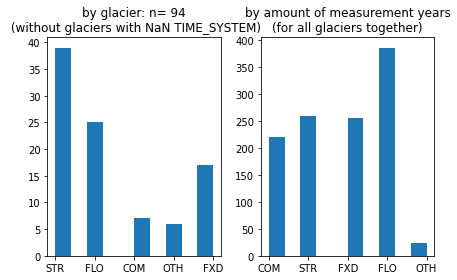

In [48]:
pd_mb_overview_no_dropna = pd_mb_overview.loc[pd_mb_overview['TIME_SYSTEM'].dropna().index]
print('amount of glaciers with unknown np.NaN given TIME_SYSTEM: ')
len(np.unique(pd_mb_overview.WGMS_ID)) - len(np.unique(pd_mb_overview_no_dropna.WGMS_ID))
plt.subplot(121)
plt.hist(pd_mb_overview_no_dropna.groupby('WGMS_ID').max()['TIME_SYSTEM']) #, bins = np.arange(0, len(date_end_winter['TIME_SYSTEM'].unique()), 1))
plt.title('by glacier: n= {}\n (without glaciers with NaN TIME_SYSTEM)'.format(len(pd_mb_overview_no_dropna.groupby('WGMS_ID').max()['TIME_SYSTEM'])))
plt.subplot(122)
plt.hist(pd_mb_overview_no_dropna['TIME_SYSTEM'])
plt.title('by amount of measurement years\n(for all glaciers together)')
plt.tight_layout()

In [49]:
pd_mb_overview['float_month_distance_to_end_april'] = pd_mb_overview['month_END_WINTER'] + pd_mb_overview['day_END_WINTER'].values/30 #- 5

In [50]:
for period in ['BEGIN_PERIOD', 'END_PERIOD']:
    pd_mb_overview[f'float_month_distance_to_october1st_{period}'] = pd_mb_overview[f'month_{period}'] + pd_mb_overview[f'day_{period}'].values/30 #- 10 - 1/30

(array([7.00e+00, 2.20e+01, 5.40e+01, 1.00e+00, 0.00e+00, 7.00e+00,
        3.97e+02, 1.06e+03, 7.60e+01, 5.00e+00]),
 array([ 1.3       ,  2.47333333,  3.64666667,  4.82      ,  5.99333333,
         7.16666667,  8.34      ,  9.51333333, 10.68666667, 11.86      ,
        13.03333333]),
 <BarContainer object of 10 artists>)

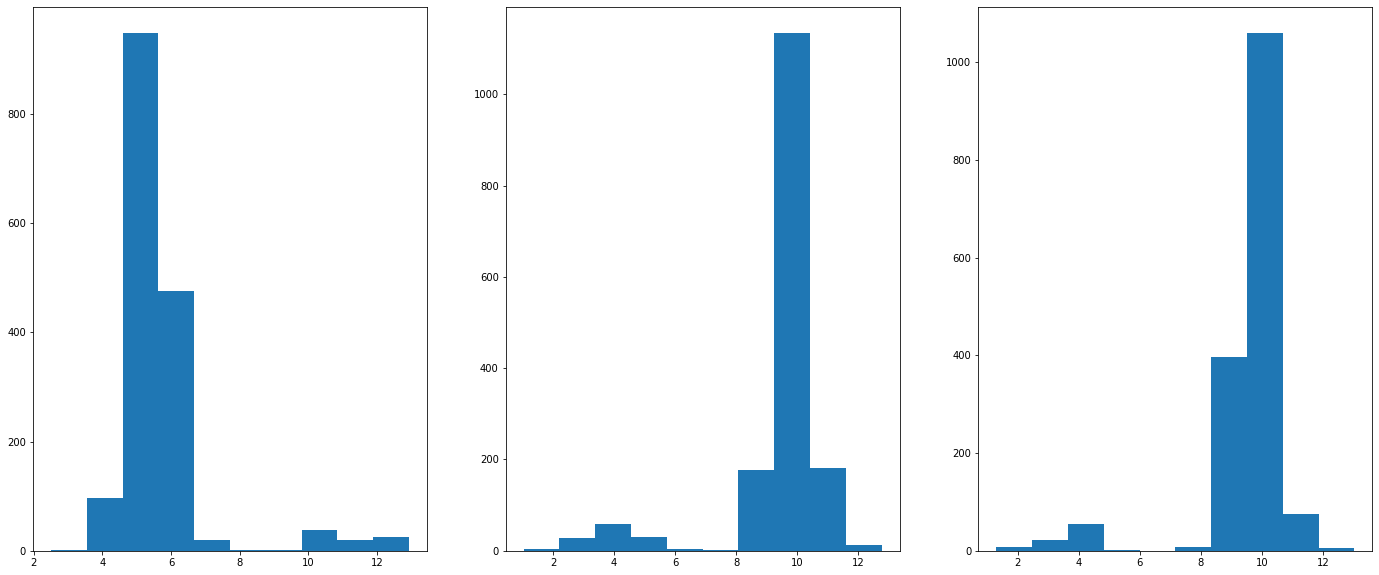

In [51]:
plt.figure(figsize=(24,10))
plt.subplot(131)
plt.hist(pd_mb_overview['float_month_distance_to_end_april'])
plt.subplot(132)
plt.hist(pd_mb_overview[f'float_month_distance_to_october1st_BEGIN_PERIOD'])
plt.subplot(133)
plt.hist(pd_mb_overview[f'float_month_distance_to_october1st_END_PERIOD'])

In [52]:
unc = 1 # 0.5
pd_mb_overview_endApril = pd_mb_overview[(pd_mb_overview['float_month_distance_to_end_april'] <=  5 + unc) & (pd_mb_overview['float_month_distance_to_end_april'] >=  5-unc)]
condi1 = (pd_mb_overview_endApril[f'float_month_distance_to_october1st_BEGIN_PERIOD'] >= 10-unc) & (pd_mb_overview_endApril[f'float_month_distance_to_october1st_BEGIN_PERIOD'] <= 10 +unc)
condi2 = (pd_mb_overview_endApril[f'float_month_distance_to_october1st_END_PERIOD'] >= 10-unc) & (pd_mb_overview_endApril[f'float_month_distance_to_october1st_END_PERIOD'] <= 10+unc)

pd_mb_overview_endApril_beginOctober = pd_mb_overview_endApril[condi1 & condi2]

In [53]:
len(pd_mb_overview_endApril_beginOctober)

1162

Remove those glaciers with now not anymore enough measurements:

In [54]:
wgms_w_enough_msm_new = pd_mb_overview_endApril_beginOctober.WGMS_ID.value_counts()[pd_mb_overview_endApril_beginOctober.WGMS_ID.value_counts()>=5].index

In [55]:
len(wgms_w_enough_msm_new)

76

In [56]:
len(pd_mb_overview_endApril_beginOctober)

1162

In [57]:
# drop those glaciers where we do not have enough measurements
for k in pd_mb_overview_endApril_beginOctober.index:
    if np.any(pd_mb_overview_endApril_beginOctober.loc[k].WGMS_ID == wgms_w_enough_msm_new):
        pass
    else:
        pd_mb_overview_endApril_beginOctober = pd_mb_overview_endApril_beginOctober.drop(k)

In [58]:
len(pd_mb_overview_endApril_beginOctober.WGMS_ID.value_counts())

76

In [59]:
pd_mb_overview_endApril_beginOctober.loc[pd_mb_overview_endApril_beginOctober.TIME_SYSTEM.isnull(), 'TIME_SYSTEM'] = 'NAN'

Text(0.5, 0, 'TIME_MEASUREMENT_SYSTEM')

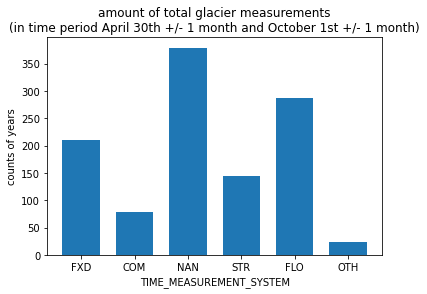

In [60]:
plt.hist(pd_mb_overview_endApril_beginOctober['TIME_SYSTEM'], align = 'left', bins=np.arange(0, 7,1), rwidth=0.7)
plt.title(f'amount of total glacier measurements\n(in time period April 30th +/- {unc} month and October 1st +/- {unc} month)')
plt.ylabel('counts of years')
plt.xlabel('TIME_MEASUREMENT_SYSTEM')

In [61]:
pd_working_winter.index = pd_working_winter.WGMS_ID

In [62]:
# glaciers
len(pd_working_winter.loc[wgms_w_enough_msm_new].sort_values('rgi_id'))

76

In [63]:
# glaciers with enough MB profiles (in northern Hemisphere because winter MB near to Oct 1st -> April 30th)
len(pd_working_winter.loc[wgms_w_enough_msm_new][pd_working_winter.loc[wgms_w_enough_msm_new].MB_profile])

# southern hemisphere tropics rgi regions: ['16', '17', '18', '19']

57

### We have removed those measurements where winter+ summer did not coincide roughly to the annual MB. Let's look at those glaciers with large differences in more detail:

In [64]:
diff_diverging = pd_working[pd_working['exist_diff_total_winter_summer_above_100']].index
pd_working[pd_working['exist_diff_total_winter_summer_above_100']]

,rgi_id,MB_profile,exist_diff_total_winter_summer_above_100,len_mb_profile,len_summer_balance,len_winter_balance,len_annual_balance
RGI60-17.14203,RGI60-17.14203,False,True,0,23,23,24.0
RGI60-11.00781,RGI60-11.00781,True,True,28,26,26,31.0
RGI60-16.01447,RGI60-16.01447,False,True,0,4,4,17.0
RGI60-02.00377,RGI60-02.00377,True,True,10,13,13,39.0
RGI60-13.45334,RGI60-13.45334,True,True,29,20,20,32.0
RGI60-14.15990,RGI60-14.15990,False,True,0,9,9,19.0
RGI60-11.03166,RGI60-11.03166,False,True,0,19,19,20.0
RGI60-13.18096,RGI60-13.18096,True,True,28,22,22,28.0
RGI60-13.08055,RGI60-13.08055,True,True,10,9,9,10.0
RGI60-10.04358,RGI60-10.04358,False,True,0,4,4,10.0


In [65]:
print(f'Number of glaciers where Winter + Summer Balance differs by more than +/- 100 kg/m2 for at least one observation: {len(diff_diverging)}')


Number of glaciers where Winter + Summer Balance differs by more than +/- 100 kg/m2 for at least one observation: 14


In [66]:
gdirs_diverging = workflow.init_glacier_directories(diff_diverging)

2022-03-01 15:02:24: oggm.workflow: Execute entity tasks [GlacierDirectory] on 14 glaciers


In [67]:
n_100 = {}
diff_100 = {}
for gdir in gdirs_diverging:
    mb = gdir.get_ref_mb_data(input_filesuffix=input_fs)
    total_min_win_sum = (mb['ANNUAL_BALANCE'] - (mb['WINTER_BALANCE']+mb['SUMMER_BALANCE']))
    n_100[gdir.rgi_id] = len(total_min_win_sum[total_min_win_sum>=100])
    diff_100[gdir.rgi_id] = total_min_win_sum[total_min_win_sum>=100].values

2022-03-01 15:02:28: oggm.utils: You are trying to set MB data on a tidewater glacier! These data will be ignored by the MB model calibration routine.


**Differences between summer and winter Balance (if above +/-100 kg/m2, and if pre-filtered by oggm default wgms pre-processing!**

In [68]:
diff_100

{'RGI60-17.14203': array([590.]),
 'RGI60-11.00781': array([110.]),
 'RGI60-16.01447': array([263.]),
 'RGI60-02.00377': array([409.]),
 'RGI60-13.45334': array([546., 325.]),
 'RGI60-14.15990': array([160.]),
 'RGI60-11.03166': array([360.]),
 'RGI60-13.18096': array([654.]),
 'RGI60-13.08055': array([140.]),
 'RGI60-10.04358': array([100.]),
 'RGI60-07.00504': array([106., 100.]),
 'RGI60-07.00240': array([440., 228.]),
 'RGI60-07.00493': array([100.]),
 'RGI60-02.17862': array([350.])}